# Info

Function:
* Rename metrics df columns for easier use
* Remove outliers
* Identify metric rows in an easy to use format
* Save result to be loaded in other notebooks

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scripts.general_utils import utils
utils.default_plot_format()

time = '10min'

data_path = 'results/raw_20min_04_15.pkl'
result_path = 'results/processed_20min_04_15.pkl'

print(result_path)
    

results/processed_10min_04_15.pkl


# Preparing and renaming column

In [501]:
data = pd.read_pickle(data_path)
data.tail(3)

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UMA (mg),UCr (g),UACR (mg/g),Diabetic Complications,Diabetic nephropathy,Diabetic retinopathy and cataract,Diabetic peripheral neuropathy,Coronary artery disease and cardiac insufficiency,Lower extremity atherosclerosis or stenosis,Carotid plaque
5372,75103.344,75701.976,90.297380,116.554065,4.087193,73.571119,1.309222e-06,0.000000,0.000920,4.502083e-06,...,4.38,10.23,0.428152,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5373,75703.428,76302.748,141.746201,199.345544,34.105534,77.700026,3.521571e-08,0.000000,0.000028,3.029743e-07,...,4.38,10.23,0.428152,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5374,76303.532,76903.204,173.745127,220.184953,22.222222,74.743195,3.165632e-09,0.001668,0.000004,1.195864e-06,...,4.38,10.23,0.428152,1.0,0.0,0.0,1.0,0.0,0.0,1.0


Keep only individuals with no complications or diabetic neuropathy only.
Rename the columns in a ways that is easier to follow.

In [502]:
data.rename(columns={
    'Diabetic Complications': 'Complications',
    'Diabetic nephropathy': 'Nephropathy',
    'Diabetic retinopathy and cataract': 'Retinopathy and cataract',
    'Diabetic peripheral neuropathy': 'DPN',
    'Coronary artery disease and cardiac insufficiency': 'Heart Disease',
    'Lower extremity atherosclerosis or stenosis': 'atherosclerosis or stenosis',
    'Carotid plaque': 'Carotid Plaque'
}, inplace=True)

In [503]:
data.sort_values(by=["DPN"], inplace=True)
new_id = {ID:i for i, ID in enumerate(data.id.unique())}
data.id = data.id.map(new_id)
print(new_id)

{'19070921': 0, '20010827': 1, '20011712': 2, '19121735': 3, '20052606': 4, '20061729': 5, '20092226': 6, '20050628': 7, '19120704': 8, '19120723': 9, '19120302': 10, '19121303': 11, '20121033': 12, '20121716': 13, '20120922': 14, '20121718': 15, '20122932': 16, '20092535': 17, '20101424': 18, '20102029': 19, '20120116': 20, '19081506': 21, '19080106': 22, '19072940': 23, '19090308': 24, '19090320': 25, '19082406': 26, '19072214': 27, '19072205': 28, '19072939': 29, '19072938': 30, '19102524': 31, '19102622': 32, '19102102': 33, '19102103': 34, '19112609': 35, '19101607': 36, '19101619': 37, '20123017': 38, '20010826': 39, '20101822': 40, '19080715': 41, '19120323': 42}


In [504]:
to_include = ['Nephropathy', 'Heart Disease', 'Nephropathy', 'Carotid Plaque', 'DPN']
to_include = ['DPN']
data = data[data[to_include].any(axis=1) | (data['Complications']==0)]

data['Condition'] = data['DPN'].apply(lambda x: 'DPN' if x else 'Diabetes')
data.tail()

data = data.dropna(subset=['DPN'])

In [505]:
conditions = data[['id', 'Complications', 'Nephropathy',
    'Retinopathy and cataract', 'DPN', 'Heart Disease',
    'atherosclerosis or stenosis', 'Carotid Plaque']]


conditions = conditions.copy().drop_duplicates().sort_values('DPN')
conditions = conditions.reset_index(drop=True)

result = conditions[['id','DPN', 'Complications', 'Nephropathy', 
    'Retinopathy and cataract', 
    'Heart Disease', 'atherosclerosis or stenosis', 
    'Carotid Plaque']].groupby('id').max()

display(result[result['Complications'] == 1].drop(columns=['Complications']))
print(result.sum())

,DPN,Nephropathy,Retinopathy and cataract,Heart Disease,atherosclerosis or stenosis,Carotid Plaque
id,,,,,,
37,1.0,0.0,0.0,1.0,0.0,0.0
38,1.0,0.0,0.0,0.0,0.0,1.0
39,1.0,1.0,0.0,0.0,0.0,0.0
40,1.0,1.0,0.0,0.0,0.0,1.0


DPN                            4.0
Complications                  4.0
Nephropathy                    2.0
Retinopathy and cataract       0.0
Heart Disease                  1.0
atherosclerosis or stenosis    0.0
Carotid Plaque                 2.0
dtype: float64


In [506]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3255 entries, 0 to 5374
Data columns (total 63 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   t_start                      3255 non-null   float64
 1   t_end                        3255 non-null   float64
 2   SDRR                         3255 non-null   float64
 3   RMSSD                        3255 non-null   float64
 4   pNN50 (%)                    3255 non-null   float64
 5   Mean HR (bpm)                3255 non-null   float64
 6   ULF Power                    3255 non-null   float64
 7   ULF Peak Frequency           3255 non-null   float64
 8   ULF Peak Power               3255 non-null   float64
 9   VLF Power                    3255 non-null   float64
 10  VLF Peak Frequency           3255 non-null   float64
 11  VLF Peak Power               3255 non-null   float64
 12  LF Power                     3255 non-null   float64
 13  LF Peak Frequency      

In [507]:
data.columns = data.columns.str.replace('/', '÷')
print(data.columns)

Index(['t_start', 't_end', 'SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)',
       'ULF Power', 'ULF Peak Frequency', 'ULF Peak Power', 'VLF Power',
       'VLF Peak Frequency', 'VLF Peak Power', 'LF Power', 'LF Peak Frequency',
       'LF Peak Power', 'HF Power', 'HF Peak Frequency', 'HF Peak Power',
       'LF÷HF Ratio', 'SD1', 'SD2', 'SD1÷SD2', 'S', 'ApEn', 'SampEn', 'DFA α1',
       'DFA α2', 'D2', 'id', 'gender', 'age', 'height', 'weight',
       'admission FBG (mmol÷L)', 'Discharge FBG (mmol÷L)', 'HbA1c (%)',
       'SBP (mmHg)', 'DBP (mmHg)', 'WBC (×109÷L)', 'N% (%)', 'Hb (g÷L)',
       'PLT (×109÷L)', 'CRP (mg÷L)', 'ALT (U÷L)', ' AST (U÷L)', 'AST÷ALT',
       'GGT (U÷L)', 'BUN (mmol÷L)', ' UA (mmol÷L)', 'TG (mmol÷L)',
       'HDL-C (mmol÷L)', 'LDL-C (mmol÷L)', 'UMA (mg)', 'UCr (g)',
       'UACR (mg÷g)', 'Complications', 'Nephropathy',
       'Retinopathy and cataract', 'DPN', 'Heart Disease',
       'atherosclerosis or stenosis', 'Carotid Plaque', 'Condition'],
      dtype='obje

In [508]:
time_metrics = ['SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)']
frequency_metrics = ['VLF Power',
       'VLF Peak Frequency', 'LF Power', 'LF Peak Frequency', 'HF Power',
       'HF Peak Frequency', 'LF÷HF Ratio']
non_linear_metrics = ['S', 'SD1', 'SD2', 'SD1÷SD2',
       'ApEn', 'SampEn', 'DFA α1', 'DFA α2', 'D2']

indicator_columns = [*time_metrics, *frequency_metrics, *non_linear_metrics]
indicator_columns

['SDRR',
 'RMSSD',
 'pNN50 (%)',
 'Mean HR (bpm)',
 'VLF Power',
 'VLF Peak Frequency',
 'LF Power',
 'LF Peak Frequency',
 'HF Power',
 'HF Peak Frequency',
 'LF÷HF Ratio',
 'S',
 'SD1',
 'SD2',
 'SD1÷SD2',
 'ApEn',
 'SampEn',
 'DFA α1',
 'DFA α2',
 'D2']

# ECG and outliers

3255


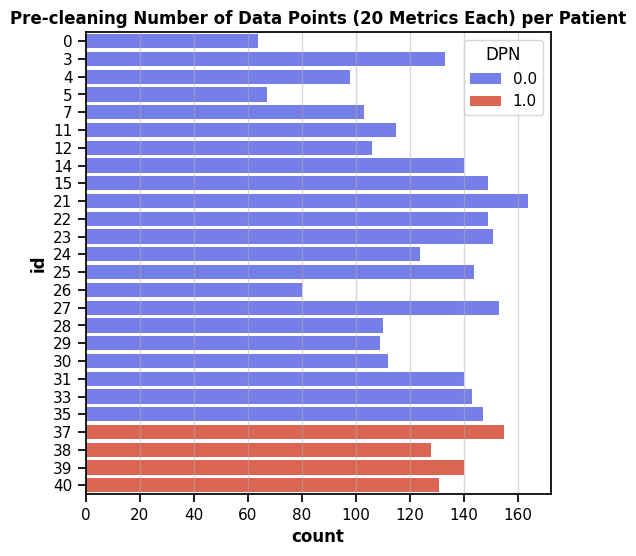

In [509]:
print(data.shape[0])
plt.figure(figsize=(6, 6))
sns.countplot(data, y='id', hue = 'DPN')
plt.title("Pre-cleaning Number of Data Points (20 Metrics Each) per Patient")
plt.grid(axis='x', alpha = 0.5)

# Outlier analysis

In [510]:
import numpy as np
import pandas as pd

def find_patient_metric_outliers(data, metric, patient_id, threshold=1.5):
    """Finds IQR outliers for patient metric"""
    patient = data[data["id"] == patient_id]
    q1 = patient[metric].quantile(0.25)
    q3 = patient[metric].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers = patient[(patient[metric] < lower_bound) | (patient[metric] > upper_bound)]
    return outliers, lower_bound, upper_bound


In [511]:
threshold = 10

def check_outliers(data, metric):
    """Returns a list of outliers for each patient for each metric"""
    outlier_table = pd.DataFrame()
    for patient in data.id.unique():

        outliers, lower_bound, upper_bound = find_patient_metric_outliers(data, metric, patient, threshold)

        if not outliers.empty:

            df = pd.DataFrame({
                "patient": patient,
                "DPN" : data[data["id"] == patient]["DPN"].values[0],
                "metric": metric,
                "t_start": outliers["t_start"].values,
                "t_end": outliers["t_end"].values,
                "o_values": outliers[metric].values,
                "lower_bound": lower_bound,
                "upper_bound": upper_bound
            })

            outlier_table = pd.concat([outlier_table, df])
    return outlier_table.reset_index(drop=True)

check_outliers(data, "SDRR").tail()

,patient,DPN,metric,t_start,t_end,o_values,lower_bound,upper_bound
21,31,0.0,SDRR,32424.128,33024.044,19044.651322,-1176.256074,1470.935135
22,33,0.0,SDRR,79249.188,79848.896,4632.090566,-593.107081,765.603403
23,33,0.0,SDRR,85253.848,85853.408,4711.372736,-593.107081,765.603403
24,38,1.0,SDRR,34875.292,35474.524,8835.514297,-596.065396,754.767928
25,38,1.0,SDRR,34219.976,34629.036,1046.216731,-596.065396,754.767928


In [512]:
data = data[data["SDRR"]<400]


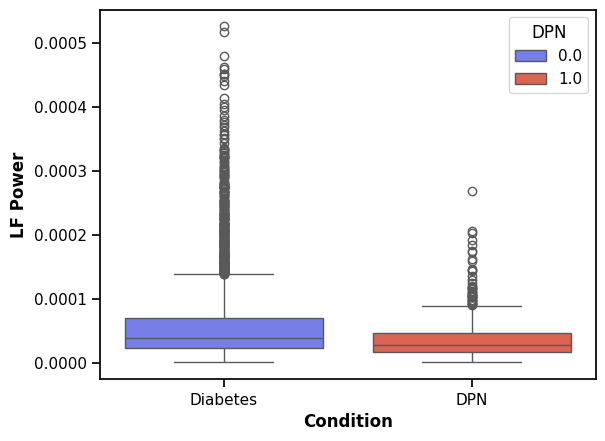

In [513]:
sns.boxplot(data=data, y='LF Power', x='Condition', hue='DPN')
data = data[data["LF Power"]<0.00017]

### Are outlier more clustered around certain patients?

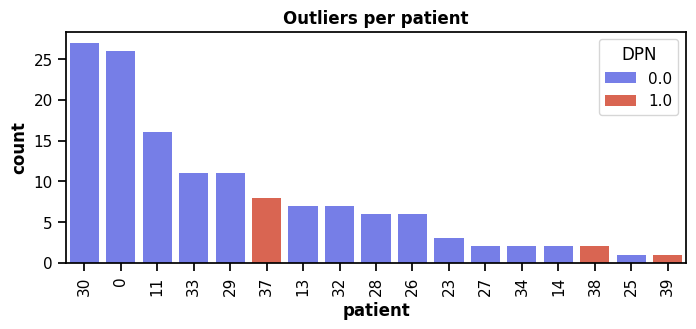

In [514]:
def draw_outlying_patients(full_outliers):
    plt.figure(figsize=(8, 3))
    # Count outliers per patient and DPN status
    patient_counts = full_outliers.groupby(['patient', 'DPN']).size().reset_index(name='count')
    patient_order = patient_counts.groupby('patient')['count'].sum().sort_values(ascending=False).index

    # Create the countplot with sorted patients
    sns.countplot(data=full_outliers, x="patient", hue="DPN", order=patient_order)
    plt.title("Outliers per patient")
    plt.xticks(rotation=90);
draw_outlying_patients(full_outliers)

* Individual with most outliers had DPN.
    * This individual appears to have outlying more outliers
* DPN individuals could be producing more outliers; however it could be just small sample effect.
* There is a lot outlier number variance between individuals.

### Which metrics are most prone to outliers?

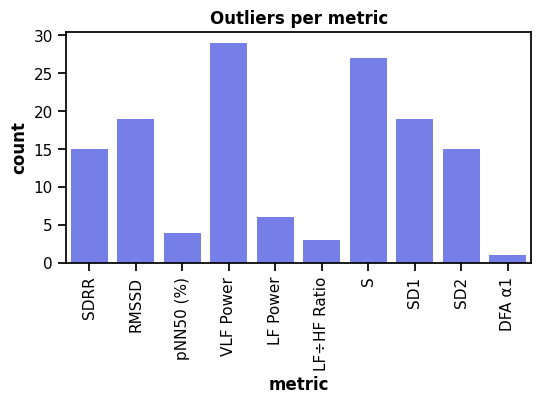

In [515]:
plt.figure(figsize=(6, 3))
sns.countplot(data=full_outliers, x="metric")
plt.title("Outliers per metric")
plt.xticks(rotation=90);

Remove outliers from linear domain metrics.

There is something going on with frequency components. Linear metrics appear to be cleanest

total outliers: 43


Text(0.5, 1.0, 'Number of Outliers per ECG segment')

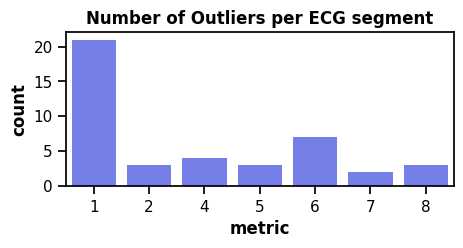

In [516]:
outlier_counts = full_outliers.groupby(["patient", "t_start"]).agg({"metric": "count"}).sort_values("metric", ascending=False)
print("total outliers:", outlier_counts.shape[0])
plt.figure(figsize=(5, 2))
sns.countplot(data=outlier_counts, x="metric")
plt.title("Number of Outliers per ECG segment")

A segment with numerous outlying values likely indicates and error in ECG measurement.
**TODO: CONFIRM IT THE MANUALLY WAY**

* Poisson distribution in outliers would indicate randomness, however, the tail is too long.
* Most outliers are single instance only.

Since segments with multiple outliers indicate errors in measurement procedure, they will be removed.

Disable automatic outlier removal for now

In [517]:
print(data.shape)

outlier_counts = outlier_counts[outlier_counts["metric"] > 0]
patient_mask = data["id"].isin(outlier_counts.index.get_level_values(0))
time_start_mask = data["t_start"].isin(outlier_counts.index.get_level_values(1))
#data = data[~(patient_mask & time_start_mask)]

print(data.shape)


(3003, 63)
(3003, 63)


Discarded 1/6th of the values. This is unacceptable and caused by Errors in the PSD metric calculation and functions Need to fix ASAP.

### SDRR

Some obvious outliers removed by hand above

## Data density

3003


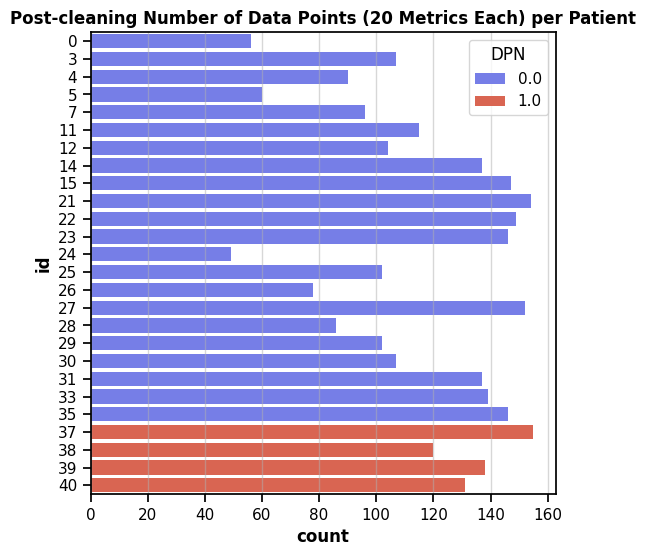

In [518]:
print(data.shape[0])

data.reset_index(drop=True, inplace=True)
plt.figure(figsize=(6, 6))
sns.countplot(data, y='id', hue = 'DPN')
plt.title("Post-cleaning Number of Data Points (20 Metrics Each) per Patient")
plt.grid(axis='x', alpha = 0.5)

# Patients as outliers

<Axes: xlabel='t_start', ylabel='id'>

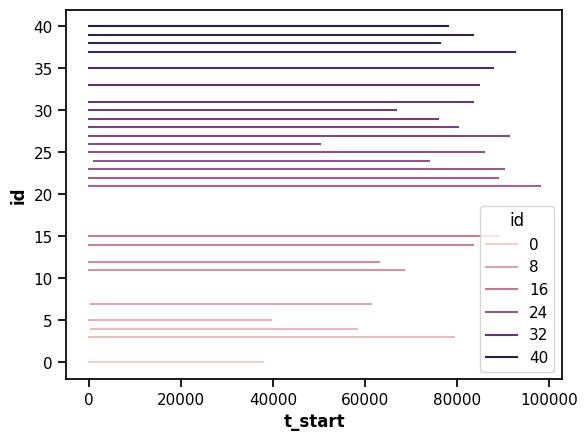

In [519]:
sns.lineplot(data=data, y='id', x='t_start', hue = 'id')
#data = data[data['id'] != 5]

# Save the data

In [520]:
import pickle

# Create a dictionary to store the data and metrics
data_to_pickle = {
    'data': data,
    'indicator_columns': indicator_columns,
    'time_metrics': time_metrics,
    'frequency_metrics': frequency_metrics,
    'non_linear_metrics': non_linear_metrics
}


# Save the dictionary to a pickle file
with open(result_path, 'wb') as file:
    pickle.dump(data_to_pickle, file)